In [1]:
import pandas as pd
#Import daily data from john hopkins database
urlinf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
infected = pd.read_csv(urlinf, error_bad_lines=False)
urldeaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(urldeaths, error_bad_lines=False)
urlrecovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(urlrecovered, error_bad_lines=False)
#Delete Lat and Long columns
infected = infected.drop(["Province/State","Lat","Long"], axis=1)
deaths = deaths.drop(["Province/State","Lat","Long"], axis=1)
recovered = recovered.drop(["Province/State","Lat","Long"], axis=1)
infected = infected.groupby(by=['Country/Region'], as_index=False).sum()
deaths = deaths.groupby(by=['Country/Region'], as_index=False).sum()
recovered = recovered.groupby(by=['Country/Region'], as_index=False).sum()

In [2]:
Selection = 'US'
startday = 60

In [3]:
infected.insert(1, 'Status', 'infected')
recovered.insert(1, 'Status', 'recovered')
deaths.insert(1, 'Status', 'death')

In [4]:
dfs = [deaths, recovered]
data = infected.append(dfs)
#total_rows1 = df['Country/Region'].count
#print (total_rows1)
data.head()

,Country/Region,Status,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,Afghanistan,infected,0,0,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,Albania,infected,0,0,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,Algeria,infected,0,0,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,Andorra,infected,0,0,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,Angola,infected,0,0,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


In [5]:
database = data.melt(id_vars=["Country/Region", "Status"], 
            var_name="Date", 
            value_name="Value")
database.columns = ['Country', 'Status','Date','Value']

In [6]:
inf = database.loc[(database['Country'] == Selection) & (database['Status'] == 'infected')]
rec = database.loc[(database['Country'] == Selection) & (database['Status'] == 'recovered')]
dea = database.loc[(database['Country'] == Selection) & (database['Status'] == 'death')]
inf.head()

,Country,Status,Date,Value
174,US,infected,1/22/20,1
738,US,infected,1/23/20,1
1302,US,infected,1/24/20,2
1866,US,infected,1/25/20,2
2430,US,infected,1/26/20,5


In [7]:
import numpy as np
inflist = inf["Value"].tolist()
reclist = rec["Value"].tolist()
dealist = dea["Value"].tolist()
I_data = np.asarray(inflist)
R_data = np.asarray(reclist)
D_data = np.asarray(dealist) 
Days = np.linspace(0,len(I_data)-startday,len(I_data)-startday)
D_data[50]

41

In [8]:
import pylab as pp
import numpy as np
from scipy import integrate, interpolate
from scipy import optimize

##initialize the data
def f(y, t, k): 
    """define the ODE system in terms of 
        dependent variable y,
        independent variable t, and
        optinal parmaeters, in this case a single variable k """
    S = y[0]
    I = y[1]
    R = y[2]
    D = y[3]
    a = k[0]
    r = k[1]
    d = k[2]
    return (-k[0]*y[0]*y[1], (k[0]*y[0]*y[1])-((k[1]+k[2])*y[1]), k[1]*y[1] ,k[2]*y[1])

def my_ls_func(x,teta):
    """definition of function for LS fit
        x gives evaluation points,
        teta is an array of parameters to be varied for fit"""
    # create an alias to f which passes the optional params    
    f2 = lambda y,t: f(y, t, teta)
    # calculate ode solution, retuen values for each entry of "x"
    r = integrate.odeint(f2,y0,x)
    #in this case, we only need one of the dependent variable values
    return r[:,3]

def f_resid(p):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        (f_resid,guess)this function"""
  
    return D_data[startday:]-my_ls_func(Days,p)


parameter values are  [ 3.47392981 -0.02071174  0.00860036]


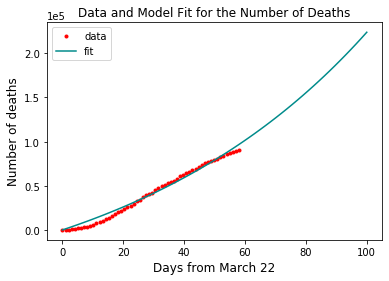

In [11]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
#solve the system - the solution is in variable c
guess = [1.27445112,0.1977401,0.07671102] #initial guess for params
y0 = [100000,I_data[startday],R_data[startday],D_data[startday]] #inital conditions for ODEs
(c,kvg) = optimize.leastsq(f_resid,guess)#get params
print ("parameter values are ",c)

# fit ODE results to interpolating spline just for fun
xeval=np.linspace(min(Days),max(Days),len(Days)) 
gls = interpolate.UnivariateSpline(xeval, my_ls_func(xeval,c), k=5, s=1)
#pick a few more points for a very smooth curve, then plot 
#   data and curve fit
xeval=np.linspace(min(Days),100,len(Days))

#Plot of the data as red dots and fit as blue line
plt.plot(Days, D_data[startday:],'.r',xeval,gls(xeval),'darkcyan')
plt.title('Data and Model Fit for the Number of Deaths')
plt.xlabel('Days from March 22',{"fontsize":12})
plt.ylabel("Number of deaths",{"fontsize":12})
plt.legend(('data','fit'),loc=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("Deathfit.png",dpi=400)
plt.show()

In [10]:
my_ls_func(xeval,c)

array([   586.        ,   2618.4270366 ,   4694.50474031,   6815.16701141,
         8981.37134409,  11194.09577317,  13454.33931969,  15763.12246569,
        18121.48768997,  20530.49967341,  22991.24605679,  25504.83780471,
        28072.40991085,  30695.12164867,  33374.1571872 ,  36110.72608981,
        38906.06387407,  41761.43263668,  44678.12151771,  47657.44741243,
        50700.75547028,  53809.41973742,  56984.84378738,  60228.46128658,
        63541.73674602,  66926.1660608 ,  70383.27731274,  73914.63137967,
        77521.8226721 ,  81206.47977389,  84970.26637876,  88814.88169274,
        92742.06169004,  96753.57931881, 100851.24590017, 105036.91141822,
       109312.465716  , 113679.8392166 , 118141.00370538, 122697.97348928,
       127352.8058842 , 132107.60269431, 136964.51050693, 141925.72239379,
       146993.47816185, 152170.06596107, 157457.82300078, 162859.13662453,
       168376.44561443, 174012.24086025, 179769.06709069, 185649.52327492,
       191656.2646494 , 1